#### Quantile Regression

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta, date, time
import calendar
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
color_pal = sns.color_palette()

#### Set parameters

In [ ]:
# define model name for result files
model_name = "Quantile_Regression"  

# define quantiles 
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

# set parametrs for model training and evaluation
test_start_date = "2024-02-22"  # test/evaluation data start
test_size = 168                 # prediction intervall for one split (168 hours = 1 week)
n_splits = 52                    # number of splits for TimeSeriesSplit

# Set Quantil-training data size in hours which is used for evaluation and final prediction
train_windows = {
    "q1_train_window": 8760 * 7,  # hours
    "q2_train_window": 8760 * 7,  # hours
    "q3_train_window": 8760 * 7,  # hours
    "q4_train_window": 8760 * 7,  # hours
    "q5_train_window": 8760 * 7,  # hours
}

# Switch features on or off
time_based_features = 1         # 0 for no time based features, 1 for dummy variables, 2 for categorical variables
lag_1week = 1                  # 0 for no lag features, 1 for lag features
lag_2week_mean = 1             # 0 for no lag features, 1 for lag features
lag_4week_mean = 1            # 0 for no lag features, 1 for lag features
perceived_temperature = 1       # 0 for no perceived temperature, 1 for perceived temperature
snow = 1                        # 0 for no snow, 1 for snow
heat_index = 1                  # 0 for no heat index, 1 for heat index

#### Load Data

In [3]:
df = pd.read_csv('../data/combined_data/combined_bike_data.csv', parse_dates=["Datetime"], index_col="Datetime")

# define time zone as ezrope/berlin to account for time shifts in original data
df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Berlin')

# convert back to utc to rmeove time shifts
df.index = df.index.tz_convert('UTC')

# remove tz awareness
df.index = df.index.tz_localize(None)

#### Prepare and Clean Data for Model

In [4]:
df = df.loc['2013-01-01':]
df.drop_duplicates(inplace=True)
nan_count = df['target'].isna().sum()
nan_indices = df[df['target'].isna()].index
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
missing_hours = full_range.difference(df.index)
duplicates = df[df.duplicated()]

upper_threshold = df["target"].quantile(0.999)
df.loc[df["target"] > upper_threshold, "target"] = upper_threshold

print(f"NaN count in target column: {nan_count}")
print("Index", nan_indices)
print("Missing hours:", missing_hours)
print("Duplicates:", duplicates)

NaN count in target column: 0
Index DatetimeIndex([], dtype='datetime64[ns]', name='Datetime', freq=None)
Missing hours: DatetimeIndex([], dtype='datetime64[ns]', freq='H')
Duplicates: Empty DataFrame
Columns: [cloud_cover, precipitation, relative_humidity_2m, shortwave_radiation, target, temperature_2m, weather_code, wind_speed_10m, public_holiday]
Index: []


#### Create Time Based Features and Lag Features

In [5]:
# function for time based dummy features
if time_based_features == 1:
    def create_time_dummies(df):

        df['hour'] = df.index.hour.astype(int)
        df['dayofweek'] = df.index.dayofweek.astype(int)
        df['month'] = df.index.month.astype(int)
        df['year'] = df.index.year.astype(int)
        
        df_dummies = pd.get_dummies(df, columns=['hour', 'dayofweek', 'month', 'year'], dtype=int, drop_first=True)
        
        return df_dummies

    df = create_time_dummies(df)

# function for categorical time based features
if time_based_features == 2:
    
    def create_time_features(df):
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['weekofyear'] = df.index.isocalendar().week.astype(int)
    
        return df

    df = create_time_features(df)

In [6]:
# add 1 week lag
if lag_1week == 1:
    df['lag_1week'] = df['target'].shift(168)

# add 2 week lag mean
if lag_2week_mean == 1:
    def calculate_lag_2week_mean(df, column_name):
        lag_4week_mean = (
            df[column_name].shift(168) + 
            df[column_name].shift(2*168) 

        ) / 2
        return lag_2week_mean

    df['lag_2week_mean'] = calculate_lag_2week_mean(df, 'target')

# add 4 week lag mean
if lag_4week_mean == 1:

    def calculate_lag_4week_mean(df, column_name):

        lag_4week_mean = (
            df[column_name].shift(168) +  
            df[column_name].shift(2*168) +  
            df[column_name].shift(3*168) +  
            df[column_name].shift(4*168)  
        ) / 4
        return lag_4week_mean

    df['lag_4week_mean'] = calculate_lag_4week_mean(df, 'target')

In [7]:
# Add percieved temperature, snow and heat index
if perceived_temperature == 1:
    df['perceived_temperature'] = (
        13.12 
        + 0.6215 * df['temperature_2m'] 
        - 11.37 * ((df['wind_speed_10m'] * 3.6) ** 0.16) 
        + 0.3965 * df['temperature_2m'] * ((df['wind_speed_10m'] * 3.6) ** 0.16)
    )
if snow == 1:
    df['snow'] = ((df['temperature_2m'] < 0) & (df['precipitation'] > 0)).astype(int)

if heat_index == 1:
    df['heat_index'] = df['temperature_2m'] + 0.55 * (1 - df['relative_humidity_2m'] / 100) * (df['temperature_2m'] - 14.5)

In [8]:
# features to be scaled
columns_to_scale = ['cloud_cover', 'precipitation', 'relative_humidity_2m','shortwave_radiation', 'temperature_2m', 'weather_code',
        'wind_speed_10m', 'lag_1week',
        'lag_2week_mean', 'lag_4week_mean', 'rolling_1day_shifted',
        'rolling_1week_shifted', 'rolling_2week_shifted',
        'rolling_3week_shifted', 'rolling_4week_shifted',
        'rolling_2month_shifted', 'rolling_3month_shifted',
        'rolling_1year_shifted', 'perceived_temperature', 'snow', 'heat_index']

#### Rolling Window and Model

In [9]:
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Copy of dataframe
data = df.copy()

# Cross-validation parameters as defined
test_start_date = pd.Timestamp(test_start_date)
test_size = test_size
n_splits = n_splits

train_data = data.loc[:test_start_date]

# Results dataframe
results = pd.DataFrame(index=data.loc[test_start_date:].index)
results["target"] = data["target"].reindex(results.index)

# Loop over quantiles
for i, quantile in enumerate(quantiles):
    train_window = train_windows[f"q{i + 1}_train_window"]
    predictions = []
    
    # Cross-validation time series split
    for split in range(n_splits):
        test_start = test_start_date + pd.Timedelta(hours=split * test_size)
        test_end = test_start + pd.Timedelta(hours=test_size - 1)
        
        # Train and test data
        train_end = test_start - pd.Timedelta(hours=1)
        train_start = max(train_end - pd.Timedelta(hours=train_window), data.index[0])
        
        train_data = data.loc[train_start:train_end]
        test_data = data.loc[test_start:test_end]

        X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
        X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

        # Standardize features (fit on train, transform on test)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Convert back to DataFrame to preserve column names and reattach index
        X_train = pd.DataFrame(X_train, columns=train_data.drop(columns=["target"]).columns, index=train_data.index)
        X_test = pd.DataFrame(X_test, columns=test_data.drop(columns=["target"]).columns, index=test_data.index)

        # Add constant for statsmodels
        X_train = sm.add_constant(X_train, has_constant="add")
        y_train = np.asarray(y_train, dtype=float)

        X_test = sm.add_constant(X_test, has_constant="add")

        # Ensure that X_test has the same columns as X_train
        X_test = X_test[X_train.columns]

        # Quantile regression model
        model = sm.QuantReg(y_train, X_train)
        result = model.fit(q=quantile)

        # Predictions
        y_pred = result.predict(X_test)
             
        pred_df = pd.DataFrame({
            "index": test_data.index,
            f"q{quantile}": y_pred
        }).set_index("index")
        
        results.loc[pred_df.index, f"q{quantile}"] = pred_df[f"q{quantile}"]
        


c:\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


KeyboardInterrupt: 

In [ ]:
results.dropna(subset=[col for col in results.columns if col.startswith("q")], inplace=True)

# sort quantile columns if quantile crossing occurs
def fix_quantile_crossing(results):
    
    quantile_columns = [col for col in results.columns if col.startswith('q')]
    
    for idx in results.index:
        sorted_values = sorted(results.loc[idx, quantile_columns].values)
        results.loc[idx, quantile_columns] = sorted_values
    
    return results

In [ ]:
results

,target,q0.025,q0.25,q0.5,q0.75,q0.975
Datetime,,,,,,
2024-02-22 00:00:00,16.0,-10.684030,4.190443,18.413935,30.775720,54.917620
2024-02-22 01:00:00,11.0,-27.643181,-10.545444,7.740418,21.117739,41.782902
2024-02-22 02:00:00,3.0,-32.447618,-19.147762,-2.772425,10.079473,27.372892
2024-02-22 03:00:00,4.0,-46.150715,-25.356126,-4.624608,9.321670,26.642886
2024-02-22 04:00:00,4.0,-52.240126,-30.889733,-7.891391,6.183488,21.228043
...,...,...,...,...,...,...
2025-02-19 19:00:00,218.0,143.912179,191.241876,221.405267,256.569468,319.838997
2025-02-19 20:00:00,149.0,91.079491,123.853273,143.034331,163.181172,190.412303
2025-02-19 21:00:00,103.0,60.104100,87.816231,106.294443,122.266455,141.743595


In [ ]:
# Resample to get daily values
results = results[['target', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']].resample('D').sum()

In [ ]:
# safe results

folder = "results"
os.makedirs(folder, exist_ok=True)
results.to_csv(f"{folder}/{model_name}.csv", index=True)

In [ ]:
results

,target,q0.025,q0.25,q0.5,q0.75,q0.975
Datetime,,,,,,
2024-02-22,3284.0,2017.260335,3331.998325,4101.443350,4740.875455,5795.893204
2024-02-23,4771.0,2714.375383,3998.055167,4557.858249,5152.854437,6187.067523
2024-02-24,3351.0,1878.243418,3065.945167,3538.260969,4066.712353,5091.160479
2024-02-25,1850.0,603.365398,1642.406965,2059.456776,2513.636063,3811.132368
2024-02-26,4518.0,2532.281600,4006.361520,4686.742487,5299.060858,6348.009242
...,...,...,...,...,...,...
2025-02-15,2819.0,1813.693258,2865.862554,3302.568884,3748.731615,4688.778109
2025-02-16,1329.0,301.316245,1202.831165,1562.461278,1887.840705,3020.852178
2025-02-17,4081.0,2456.648272,3626.279079,4173.496048,4669.424169,5468.214559


<AxesSubplot:xlabel='Datetime'>

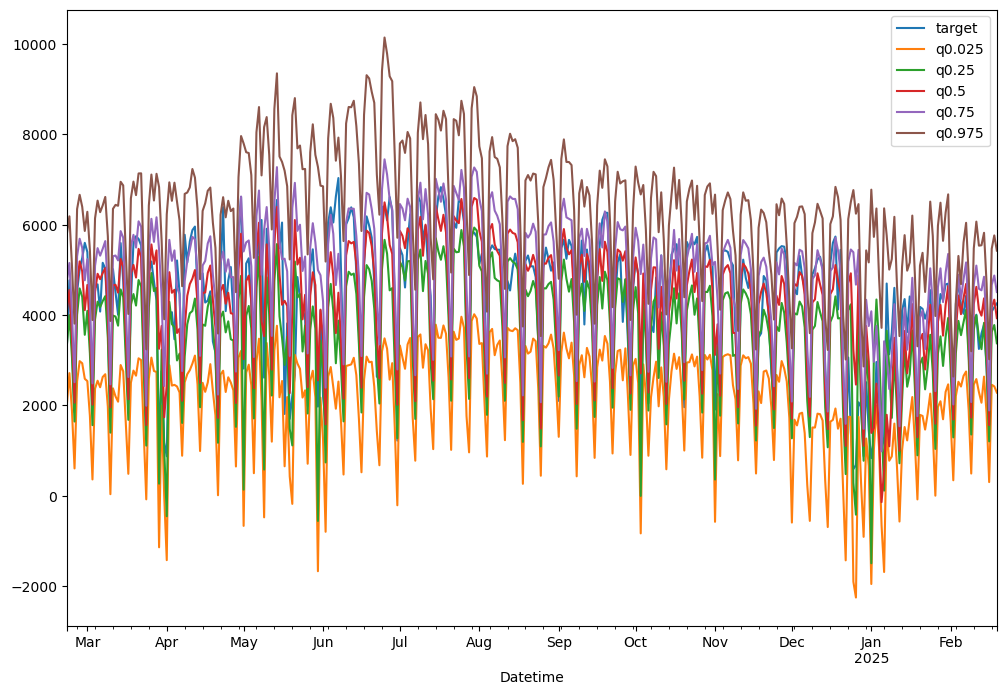

In [ ]:
results.plot(figsize=(12,8))

#### Evaluation

In [ ]:
# calucate quantile losses of all predictions
quantile_losses = {}

for q in quantiles:
    
    y_pred = results[f'q{q}']
    y_true = results['target']
    
    # pinball loss function multiplied by 2
    quantile_loss = np.where(y_pred > y_true, 
                             2 * (1 - q) * (y_pred - y_true), 
                             2 * q * (y_true - y_pred))
    
    quantile_losses[f'Quantile_{q}'] = quantile_loss.mean()

# losses of all quantile
total_loss_score = sum(quantile_losses.values())

# show results
print("Average loss by quantile:")
for quantile, loss in quantile_losses.items():
    print(f"{quantile}: {loss}")

print(f"\nTotal loss score over all quantiles: {total_loss_score}")

Average loss by quantile:
Quantile_0.025: 110.48425158117382
Quantile_0.25: 474.38695532026486
Quantile_0.5: 568.3552844580629
Quantile_0.75: 482.7682697841744
Quantile_0.975: 106.82089613316154

Total loss score over all quantiles: 1742.8156572768376


In [ ]:
# filter only relevant target horizons
results['dayofweek'] = results.index.dayofweek

horizons_dict = {}

# Target-Horizons mit den entsprechenden Stundenbezeichnungen
target_horizons = [
    {"dayofweek": 1, "name": "1 day"},  # Dienstag
    {"dayofweek": 2, "name": "2 day"},  # Mittwoch
    {"dayofweek": 3, "name": "3 day"},  # Donnerstag
    {"dayofweek": 4, "name": "4 day"},  # Freitag
    {"dayofweek": 5, "name": "5 day"},  # Samstag
    {"dayofweek": 6, "name": "6 day"},  # Sonntag
]


for horizon in target_horizons:
    # Daten für den aktuellen Zeithorizont filtern
    horizon_data = results[(results["dayofweek"] == horizon["dayofweek"])]
    horizon_data = horizon_data.drop(columns=["dayofweek"])

    # DataFrame unter dem angegebenen Namen speichern
    horizons_dict[horizon["name"]] = horizon_data

In [ ]:
# quantile losses target horizons
def calculate_quantile_losses(horizons_dict, quantiles):
    all_quantile_losses = {}
    
    for key, df in horizons_dict.items():
        quantile_losses = {}
        for q in quantiles:
            y_pred = df[f'q{q}']
            y_true = df['target']
            quantile_loss = np.where(y_pred > y_true, 2 * (1 - q) * (y_pred - y_true), 2 * q * (y_true - y_pred))
            quantile_losses[f'q{q}'] = quantile_loss.mean()
        
        total_loss_score = sum(quantile_losses.values())
        quantile_losses['Total_Loss_Score'] = total_loss_score
        all_quantile_losses[key] = quantile_losses
    
    return all_quantile_losses

quantile_loss_results = calculate_quantile_losses(horizons_dict, quantiles)

horizon_results_df = pd.DataFrame(quantile_loss_results).T
horizon_results_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total_Loss_Score
1 day,145.016594,621.707892,697.819409,506.466280,105.152182,2076.162356
2 day,121.420526,478.280062,594.068608,504.218992,103.948807,1801.936994
3 day,119.295815,589.140526,694.360087,600.064348,108.203331,2111.064108
4 day,111.062965,581.107737,673.876562,545.353278,107.217346,2018.617888
5 day,85.604090,334.153559,444.284716,412.256286,107.866474,1384.165126
6 day,77.551613,241.746319,273.773441,304.363944,112.268317,1009.703634


#### Final Evaluation Score

In [ ]:
horizon_results_df.sum()

q0.025                659.951604
q0.25                2846.136096
q0.5                 3378.182824
q0.75                2872.723127
q0.975                644.656456
Total_Loss_Score    10401.650106
dtype: float64